### Projected air temperature anomalies in UKESM1 model output

The data used for this investigation was derived from a single UKESM1 run using its default low-resolution setup. The run followed the historical setup from 1850-2014 (Eyring et al., 2016), and branched at 2015 into different scenarios for the years 2015-2100 based on shared socioeconomic pathways (SSPs) and climate outcomes for 2100 driven by prescribed radiative forcings (O’Neill et al., 2016). To assess changes to air temperature in the northern high latitudes (NHL), the variable analysed was monthly surface air temperature at 1.5 m. The regional focus was the northern permafrost zone, consisting of latitudes greater than 60 degres N.

In [1]:
#load packages
import xarray as xr
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

import scipy

In [7]:
#functions to load data and derive anomaly compared to 1850-1900 baseline

def load_data(info):
    '''function to load data for variable and scenario
    Arguments:
    =========
    info = array of str, ccontaining variable[0], letter[1], scenario[2]'''
    path1 = f'../02-data/ukesm1-output/{info[0]}_{info[1]}mon_UKESM1-0-LL_historical_r1i1p1f2_gn_*.nc'
    path2 = f'C../02-data/ukesm1-output/{info[0]}_{info[1]}mon_UKESM1-0-LL_{info[2]}_r1i1p1f2_gn_*.nc'
    data1 = xr.open_mfdataset(paths=path1,combine='by_coords')
    data2 = xr.open_mfdataset(paths=path2,combine='by_coords')
    data3 = xr.concat([data1,data2],dim='time')
    
    return data3

def s_anom(info,months,startyear=1850,endyear=2100,latmin=-90,latmax=90):
    '''function to generate seasonal surface air temperature anomaly in def C for given months and timeframe 
    Arguments:
    =========
    info = array of str, ccontaining variable[0], letter[1], scenario[2]#
    months = list of int containing numbered months
    startyear = first year of time slice
    endyear = last year of time slice
    latmin = minimum latitude
    latmax = maximum latitude'''
    
    d = load_data(info)

    tas= d.tas
    lon= d.lon
    lat= d.lat
    
    #define weights
    tas_slice = tas.sel(lat=slice(latmin,latmax))

    weights = np.cos(np.deg2rad(tas_slice.lat))
    weights.name = "weights"

    tas_weighted = tas_slice.weighted(weights)
    tas_wmn = tas_weighted.mean(('lon','lat'))
        
    #get months only
    s = tas_wmn.sel(time=tas_wmn['time.month'].isin(months))
    s1 = s.groupby('time.year').mean('time')
    
    #get climatology for each month
    bl = s.sel(time=slice('1850-01-01', '1900-12-16'))
    bl1 = bl.groupby('time.year').mean('time')
    bl2 = bl1.mean()
    
    s2 = s.sel(time=slice(f'{startyear}-01-01',f'{endyear}-12-16'))
    s3 = s2.groupby('time.year').mean('time')
    
    #final anomalies
    anom = s3 - bl2

    
    return anom

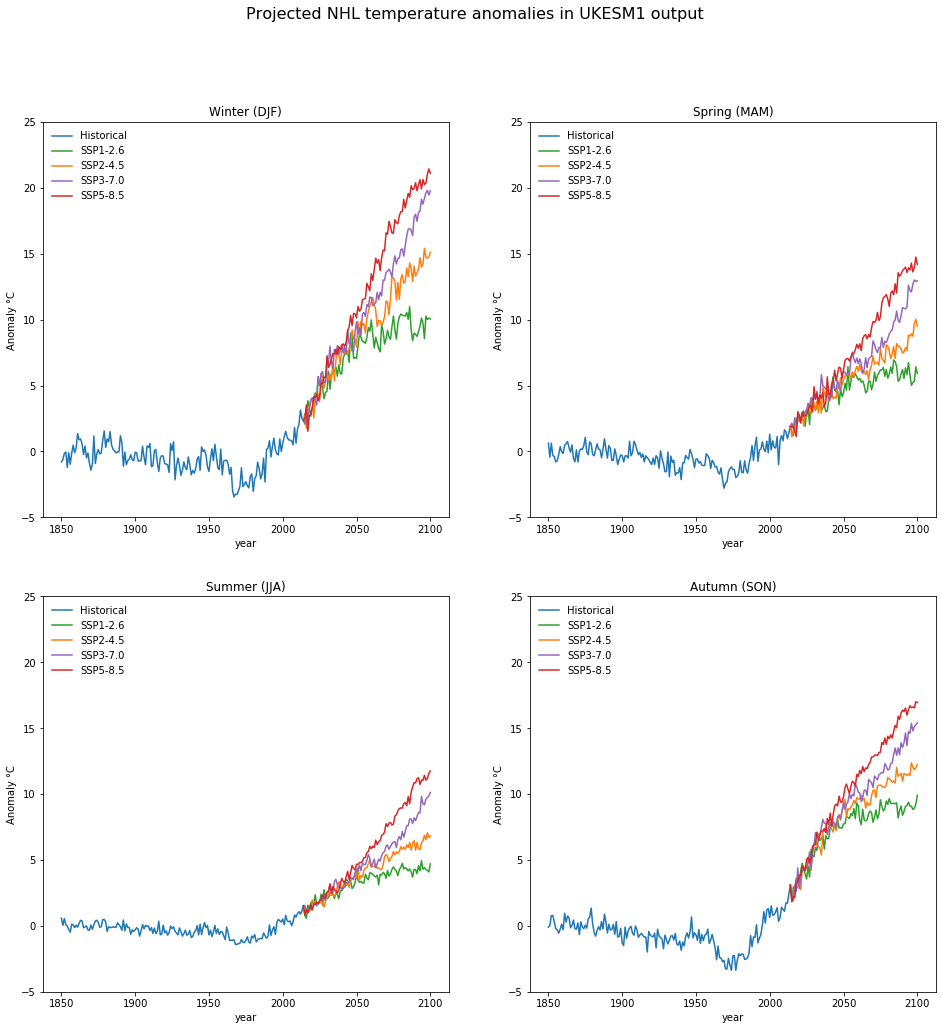

In [10]:
#set up figure

fig,axes = plt.subplots(nrows=2,ncols=2,figsize=(16,16))
fig.suptitle('Projected NHL temperature anomalies in UKESM1 output',fontsize=16)
titles = ('Winter (DJF)','Spring (MAM)','Summer (JJA)','Autumn (SON)')
scen = ('ssp126','ssp245','ssp370','ssp585')
season = ((12,1,2),(3,4,5),(6,7,8),(9,10,11))
colours = ('#2CA02C','#FF7F0E','#9467BD','#D62728')
labels = ('SSP1-2.6','SSP2-4.5','SSP3-7.0','SSP5-8.5')

x=range(2014,2101)
y=range(1850,2015)

#plot on subplot
for ax,m,t in zip(axes.flat,season,titles):
    ax.set_title(t)
    ax.set(ylabel='Anomaly \u00B0C')
    ax.set(xlabel='year')
    ax.set_ylim([-5,25])
    ax.plot(y,s_anom(['tas','A','ssp126'],m,endyear=2014, latmin=60),color='#1F77B4',label='Historical')
    for s,c,la in zip(scen,colours,labels):      
        ax.plot(x,s_anom(['tas','A',s],m,startyear=2014,latmin=60),color=c,label=la)
    ax.legend(loc='upper left',frameon=False)


### References

Eyring, V. et al. (2016) Overview of the Coupled Model Intercomparison Project Phase 6 (CMIP6) experimental design and organization. Geoscientific Model Development. [Online] 9 (5), 1937–1958.

O’Neill, B. C. et al. (2016) The Scenario Model Intercomparison Project (ScenarioMIP) for CMIP6. Geoscientific Model Development. [Online] 9 (9), 3461–3482.